In [297]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import line_search
from scipy.optimize import minimize

In [406]:
### SETTINGS
MAX_COUNT_ITER = 1000
EPS = 10**(-5)
h = 0.001 * np.ones(DIM)
OUT_K = 40
freq = 200 

In [435]:
def vec_str(vec):
    str = '('
    for i in range(DIM):
        str += '{:>6.3f} '.format(vec[i]);            
    str += ')'
    return str

def vec_str_long(vec):
    str = '('
    for i in range(DIM):
        str += '{:>14.11f} '.format(vec[i]);            
    str += ')'
    return str

In [474]:
class NOM:
    def __init__(self,f_type='n',func=0, A=np.zeros((DIM,DIM)),
                 b=np.zeros(DIM), c=0, x=np.zeros(DIM)):
        self.type=f_type
        if (f_type == 'q'):
            self.A = A
            self.b = b
            self.c = c
            self.f = lambda x: (1/2) * ((A@x)@x) + b@x + c
        else:
            self.f = func
        self.x0 = x
        
    def grad(self,x):
        if (self.type == 'q'):
            return self.A @ x + self.b
        else:
            I = np.eye(DIM)
            return np.array([(self.f(x + h * I_vec) - self.f(x - h * I_vec))
                             / (2.0 * (h @ I_vec)) for I_vec in I])
    
    def hesse(self, x):
        I = np.eye(DIM)
        return np.array([(self.grad(x + h * I_vec) - self.grad(x - h * I_vec))
                         / (2.0 * (h @ I_vec)) for I_vec in I])
    
    
    ### STOP CONDITIONS
    def stop(self,x1,x2,k):
        d1 = norm(x2-x1)
        d2 = abs(self.f(x2)-self.f(x1))
        d3 = norm(self.grad(x))
        
        plt.xlabel('iteration')
        plt.ylabel('| f(x_next) - f(x_prev) | ')    
        
        condition = (d1 < EPS) and (d2 < EPS) and (d3 < EPS)
        if not condition:
            plt.scatter(k, d1)
        return condition
    
    ### FINDING ALPHA
    def alpha_quadr(self,x,step): 
        return -np.dot((self.A.dot(x)+self.b),step) / (self.A.dot(step) @ step)
    
    def alpha_split(self,x,step,b=1,l=0.5,q=0.1):
        alpha = b
        #while (f(x+alpha*step) >= f(x)):
        while self.f(x+alpha*step) > self.f(x) + q * alpha * (self.grad(x) @ step):
            alpha *= l
        return alpha
    
    ### FINDING BETA
    def beta_quadr(self,x_prev,x_next,step_prev):
        return ((self.grad(x_next) @ self.A.dot(step_prev))
                / (step_prev @ self.A.dot(step_prev)))
    
    def beta_non_quadr(self,x_prev,x_next,step_prev):
        return ((self.grad(x_next) @ self.grad(x_next) - self.grad(x_prev))
                / (self.grad(x_next) @ self.grad(x_next)))
    
    ### Спряжених напрямків
    def conjugate_directions(self):
        self.fout_begin('output.txt')
        self.fout_init(self.x0)
        
        k = -1
        flag = True
        find_beta = self.beta_quadr if self.type == 'q' else self.beta_non_quadr
        find_alpha = self.alpha_quadr if self.type == 'q' else self.alpha_split
        
        x_next = self.x0
        step_next = - self.grad(x_next)
        while (k < MAX_COUNT_ITER):
            x_prev = x_next  
            step_prev = step_next
            alpha = find_alpha(x_prev,step_prev)
            x_next = x_prev + alpha * step_prev
            
            if (self.type != 'q') and (k // freq == 0):
                beta = 0
            else:
                beta = find_beta(x_prev,x_next,step_prev)
            step_next = - self.grad(x_next) + beta * step_prev
            k += 1
            if k < OUT_K:
                self.print_inter(k,alpha,x_prev,step_prev)
            else:
                if flag == True:
                    print('...')
                    flag = False
            self.fout_inter(k,alpha,x_prev,step_prev)
            #self.fout_inter(k,alpha,x_next,step_next)
            if self.stop(x_prev,x_next,k) or (alpha < EPS):
                break
        self.fout_result(k,x_next)
        self.print_result(k,x_next)
        self.fout.close()
        return x_next
    
    ########################################################################################
    ### Квазі-Ньютонівські
    def delta_H(self,H_pr,x_nxt,x_pr):
        dx = x_nxt - x_pr
        dy = self.grad(x_nxt)-self.grad(x_pr)
        z = dx - H_pr @ dy    
        return np.outer(z,z) / (z @ dy)    
    
    def Quasi_Newton(self):
        self.fout_begin('output_quasi_newton.txt')
        self.fout_init(self.x0)
        
        k = -1
        flag = True
        find_alpha = self.alpha_quadr if self.type == 'q' else self.alpha_split
        
        x_nxt = self.x0
        H_nxt = np.identity(DIM)

        while (k < MAX_COUNT_ITER):
            x_pr = x_nxt
            H_pr = H_nxt
            step_pr = - H_pr @ self.grad(x_pr)
            alpha = find_alpha(x_pr,step_pr)
            #alpha = line_search(self.f, self.grad, x_pr, step_pr)[0]
            x_nxt = x_pr + alpha * step_pr 
            k += 1
            if k < OUT_K:
                self.print_inter(k,alpha,x_pr,step_pr)
            else:
                if flag == True:
                    print('...')
                    flag = False    
            self.fout_inter(k,alpha,x_pr,step_pr)
            if self.stop(x_pr,x_nxt,k) or (alpha < EPS):
                break
            else:
                H_nxt = H_pr + self.delta_H(H_pr,x_nxt,x_pr)
        self.fout_result(k,x_nxt)
        self.print_result(k,x_nxt)
        self.fout.close()
        return x_nxt

    ### OUTPUT
    def fout_begin(self,filename):
        self.fout = open(filename, 'w')
        return
    
    def fout_init(self,x0):
        print('The initial point is {}\n'.format(self.x0))
        print('  k|'+' '*8+'x'+' '*9+'|'+' alpha '+ '|'+' '*7+'step'+' '*7)
        self.fout.write('The initial point is {}\n\n'.format(self.x0))
        self.fout.write('  k|'+' '*16+'x'+' '*17+'|'+' '*5+'alpha'+' '*5+ '|'+' '*15+
                   'step'+' '*15+'\n')
        pass
    
    def fout_inter(self,k,alpha,x,step):
        str_k = '{:>3}| '.format(k)
        str_alpha =' | {:<13.11f} | '.format(alpha)
        self.fout.write(str_k + vec_str_long(x) + str_alpha + vec_str_long(step) + '\n')
        pass
    
    def fout_result(self,k,x):
        self.fout.write('\nTOTAL ITERATIONS: {}\n'.format(k))
        self.fout.write('SOLUTION: x    = ' + vec_str(x))
        self.fout.write('VALUE:    f(x) =  {:>10.7f}\n'.format(self.f(x)))
        pass
    
    def print_inter(self,k,alpha,x,step):
        str_k = '{:>3}| '.format(k)
        str_alpha =' | {:<5.3f} | '.format(alpha)
        print(str_k+vec_str(x)+str_alpha+vec_str(step))
        pass
    
    
    def print_result(self,k,x):
        print('\nTOTAL ITERATIONS: {}'.format(k))
        print('SOLUTION: x    = ' + vec_str(x))
        print('VALUE:    f(x) =  {:>10.7f}\n'.format(self.f(x)))
        pass

# КВАЗІНЬЮТОНІВСЬКИЙ

### КВАДРАТИЧНА ФУНКЦІЯ

The initial point is [10 99]

  k|        x         | alpha |       step       
  0| (10.000 99.000 ) | 0.125 | (-20.099 -791.010 )
  1| ( 7.486  0.077 ) | 0.500 | (-14.974  0.097 )
  2| (-0.000  0.125 ) | 1.000 | ( 0.000 -0.000 )

TOTAL ITERATIONS: 2
SOLUTION: x    = (-0.000  0.125 )
VALUE:    f(x) =   3.9375000



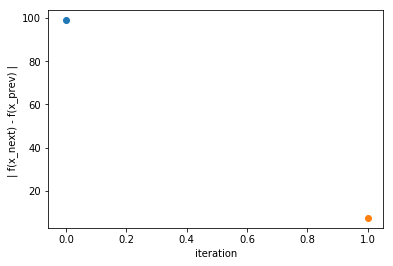

In [475]:
DIM = 2
x0 = np.zeros(DIM)
x0 = np.array([10,99])
optimization = NOM(f_type='q',A=np.array([[2, 0.001], [0.001, 8]]), 
                   b=np.array([0, -1]), c=4, x=x0)
x = optimization.Quasi_Newton()
plt.show()

### ЗВИЧАЙНА ФУНКЦІЯ

The initial point is [1 2]

  k|        x         | alpha |       step       
  0| ( 1.000  2.000 ) | 0.062 | (-16.000 -40.000 )
  1| (-0.000 -0.500 ) | 0.250 | ( 3.059 -1.381 )
  2| ( 0.765 -0.845 ) | 1.000 | (-0.119  0.263 )
  3| ( 0.646 -0.582 ) | 0.000 | (-0.139 -0.023 )

TOTAL ITERATIONS: 3
SOLUTION: x    = ( 0.646 -0.582 )
VALUE:    f(x) =   0.9880159



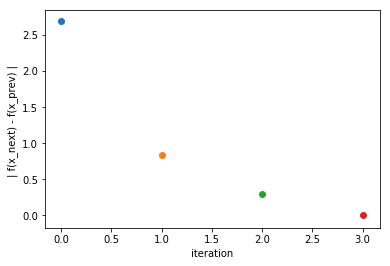

In [476]:
x0 = np.array([1,2])
optimization = NOM(f_type='n',func=f_test1, x=x0)
optimization.Quasi_Newton()
plt.show()

# СПРЯЖЕНИХ НАПРЯМКІВ

### КВАДРАТИЧНА ФУНКЦІЯ

The initial point is [ 10 -23]

  k|        x         | alpha |       step       
  0| (10.000 -23.000 ) | 0.126 | (-19.977 184.990 )
  1| ( 7.481  0.326 ) | 0.496 | (-15.093 -0.406 )
  2| (-0.000  0.125 ) | 0.125 | (-0.000  0.000 )

TOTAL ITERATIONS: 2
SOLUTION: x    = (-0.000  0.125 )
VALUE:    f(x) =   3.9375000



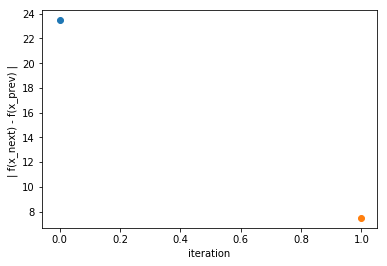

In [477]:
DIM = 2
x0 = np.zeros(DIM)
x0 = np.array([10,-23])
optimization = NOM(f_type='q',A=np.array([[2, 0.001], [0.001, 8]]), 
                   b=np.array([0, -1]), c=4, x=x0)
optimization.conjugate_directions()
plt.show()

### ЗВИЧАЙНА ФУНКЦІЯ

The initial point is [1 2]

  k|        x         | alpha |       step       
  0| ( 1.000  2.000 ) | 0.062 | (-16.000 -40.000 )
  1| (-0.000 -0.500 ) | 0.016 | ( 3.754 58.962 )
  2| ( 0.059  0.421 ) | 0.250 | ( 3.958 -0.305 )
  3| ( 1.048  0.345 ) | 0.125 | (-1.104 -1.680 )
  4| ( 0.910  0.135 ) | 0.125 | ( 0.919 -0.457 )
  5| ( 1.025  0.078 ) | 0.125 | (-0.331 -0.329 )
  6| ( 0.984  0.037 ) | 0.125 | ( 0.189 -0.142 )
  7| ( 1.007  0.019 ) | 0.125 | (-0.088 -0.077 )
  8| ( 0.996  0.009 ) | 0.125 | ( 0.046 -0.037 )
  9| ( 1.002  0.005 ) | 0.125 | (-0.022 -0.019 )
 10| ( 0.999  0.002 ) | 0.125 | ( 0.011 -0.009 )
 11| ( 1.000  0.001 ) | 0.125 | (-0.006 -0.005 )
 12| ( 1.000  0.001 ) | 0.125 | ( 0.003 -0.002 )
 13| ( 1.000  0.000 ) | 0.125 | (-0.001 -0.001 )
 14| ( 1.000  0.000 ) | 0.125 | ( 0.001 -0.001 )
 15| ( 1.000  0.000 ) | 0.125 | (-0.000 -0.000 )
 16| ( 1.000  0.000 ) | 0.125 | ( 0.000 -0.000 )
 17| ( 1.000  0.000 ) | 0.125 | (-0.000 -0.000 )
 18| ( 1.000  0.000 ) | 0.125 | ( 0.00

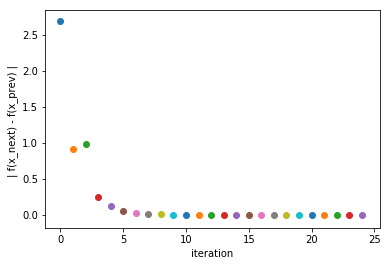

In [478]:
x0 = np.array([1,2])
optimization = NOM(f_type='n',func=f_test1, x=x0)
optimization.conjugate_directions()
plt.show()

In [469]:
### TARGET FUNCTIONS 
def f_test1(x):
    # The true solution of the problem is (1, 0)
    # The value of function in this point is 0
    DIM = 2
    return x[0]**4 + x[1]**4 + 2 * x[0]**2 * x[1]**2 - 4 * x[0] + 3

def f_test2(x):
    # The true solution of the problem is (2.39395,2.39395)
    # The value of function in this point is 5.10682
    DIM = 2
    return (x[0]**2 + x[1]**2 - 11)**2 +(x[0] + x[1] - 7)**2

def f_test3(x):
    # The true solution of the problem is (5, 3)
    # The value of function in this point is 0
    DIM = 2
    return ((x[0]**2 + 12 * x[1]**2 - 1)**2 + 
            (49 * x[0]**2 + 49 * x[1]**2 + 84 * x[0] + 232 * x[1] - 681)**2)

def f_test4(x):
    # The true solution of the problem is (5, 3)
    # The value of function in this point is 0
    DIM = 2
    return 4 * (x[0] - 5)**2 + (2 * x[1] - 6)**2

def f_test5(x):
    # The true solution of the problem is (1, 1)
    # The value of function in this point is -1
    DIM = 2
    return x[0]**3 + x[1]**2 - 3 * x[0] - 2 * x[1] + 2

def f_myvar(x):  
    # The true solution of the problem is (-0.0000625,  0.1250000)
    # The value of function in this point is  2.5626251
    DIM = 2
    return x[0]**2 + 4.0 * x[1]**2 + 0.001 * x[0] * x[1] - x[1]  

def f_Rosenbrock(x):
    # The true solution of the problem is (1, 1)
    # The value of function in this point is 0
    DIM = 2
    return 100.0 * (x[1] - x[0]**2)**2 + (1.0 - x[0])**2 